<a href="https://colab.research.google.com/github/alexandre-pinon/zoidberg-2.0/blob/main/zoidberg_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<header align="center">
  <h1>* T-DEV *</h1>
  <h1>~ Zoidberg 2.0 ~</h1>
  <p>
    <i>Alexandre.P | Bryan.S | Camille.V | Liza.H | Théo.M</i>
  </p>
  <img src="https://media.istockphoto.com/photos/robot-with-education-hud-picture-id966248982?k=20&m=966248982&s=612x612&w=0&h=gq35V9G0kfjKu0ttr90c8p0VraNtqPDkTvqWQ8oXzCk=" alt="AI img"/>
  <h2>Given some X-ray images, use machine learning to help doctors detecting pneumonia.</h2>
</header>

# Notebook config

## Constants

In [1]:
BINARY_DATASET_DIR = "datasets/chest_Xray_binary"
MULTI_DATASET_DIR = "datasets/chest_Xray_multi"
SEED = 12
IMG_SIZE = 224, 224
BATCH_SIZE = 32
EPOCHS = 20

## Load data & helpers

In [2]:
# !git clone -b colab-data "https://github.com/alexandre-pinon/zoidberg-2.0.git"

In [3]:
# !wget https://raw.githubusercontent.com/alexandre-pinon/zoidberg-2.0/main/helpers.py

## Imports

In [2]:
import os
import pathlib
import random

import helpers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf

from tensorflow.keras import Model, layers, optimizers, models, metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [69]:
import importlib
importlib.reload(helpers)

<module 'helpers' from '/home/nowaffle/epitech/zoidberg-2.0/helpers.py'>

# Data analysis

## Datasets distribution

In [3]:
helpers.walk_through_dir(BINARY_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_binary'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/pneumonia'.
There are 0 directories and 8 images in 'datasets/chest_Xray_binary/val/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/test'.
There are 0 directories and 390 images in 'datasets/chest_Xray_binary/test/pneumonia'.
There are 0 directories and 234 images in 'datasets/chest_Xray_binary/test/normal'.
There are 2 directories and 0 images in 'datasets/chest_Xray_binary/train'.
There are 0 directories and 3875 images in 'datasets/chest_Xray_binary/train/pneumonia'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_binary/train/normal'.


In [4]:
helpers.walk_through_dir(MULTI_DATASET_DIR)

There are 3 directories and 0 images in 'datasets/chest_Xray_multi'.
There are 2 directories and 0 images in 'datasets/chest_Xray_multi/val'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/normal'.
There are 0 directories and 8 images in 'datasets/chest_Xray_multi/val/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/test'.
There are 0 directories and 148 images in 'datasets/chest_Xray_multi/test/virus'.
There are 0 directories and 234 images in 'datasets/chest_Xray_multi/test/normal'.
There are 0 directories and 242 images in 'datasets/chest_Xray_multi/test/bacteria'.
There are 3 directories and 0 images in 'datasets/chest_Xray_multi/train'.
There are 0 directories and 1345 images in 'datasets/chest_Xray_multi/train/virus'.
There are 0 directories and 1341 images in 'datasets/chest_Xray_multi/train/normal'.
There are 0 directories and 2530 images in 'datasets/chest_Xray_multi/train/bacteria'.


As we can see, the datasets are **unbalanced**:
* There is almost 3 times as more pneumonia images than normal images in the binary dataset
* There is almost 2 times as more bacteria images than normal and virus images in the binary dataset

There is no virus image in both val directories so we'll use it as a small graphical test dataset for **binary** classification only.

We need to **split** the train set to make our own validation set.

In [5]:
binary_train_dir = f"{BINARY_DATASET_DIR}/train/"
multi_train_dir = f"{MULTI_DATASET_DIR}/train/"
val_dir = f"{BINARY_DATASET_DIR}/val/"
binary_test_dir = f"{BINARY_DATASET_DIR}/test/"
multi_test_dir = f"{MULTI_DATASET_DIR}/test/"

In [6]:
binary_class_names = sorted(os.listdir(binary_train_dir))
multi_class_names = sorted(os.listdir(multi_train_dir))

In [7]:
normal_train_img_count = len(os.listdir(f"{binary_train_dir}normal"))
pneumonia_train_img_count = len(os.listdir(f"{binary_train_dir}pneumonia"))
bacteria_train_img_count = len(os.listdir(f"{multi_train_dir}bacteria"))
virus_train_img_count = len(os.listdir(f"{multi_train_dir}virus"))

total_train_img_count = normal_train_img_count + pneumonia_train_img_count
assert (total_train_img_count == normal_train_img_count +
        bacteria_train_img_count + virus_train_img_count)


## Datasets visualization

Let's take a look at a few images of the train sets

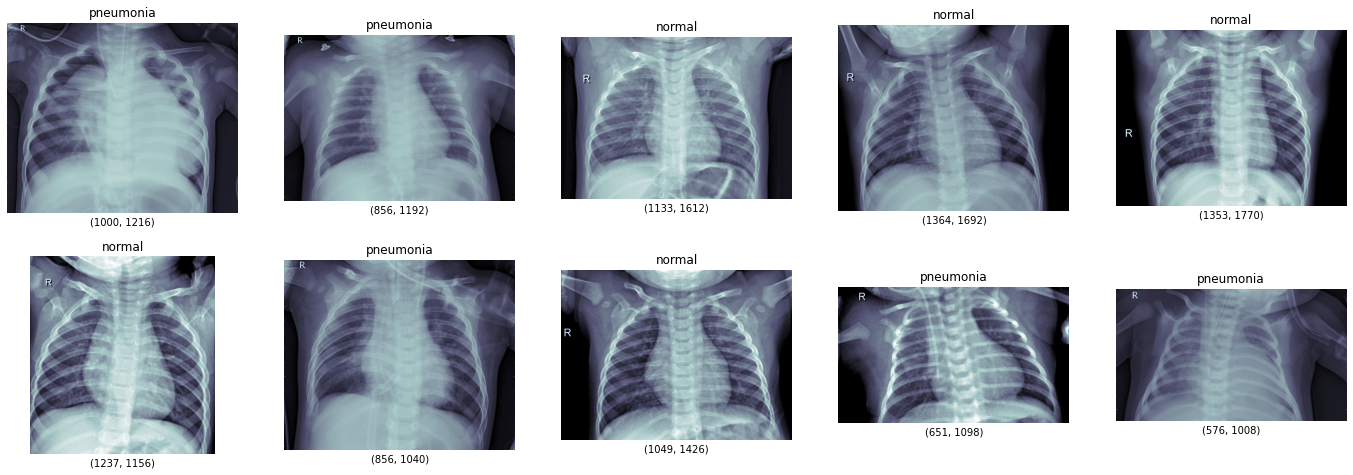

In [8]:
helpers.view_random_images(binary_train_dir, binary_class_names)

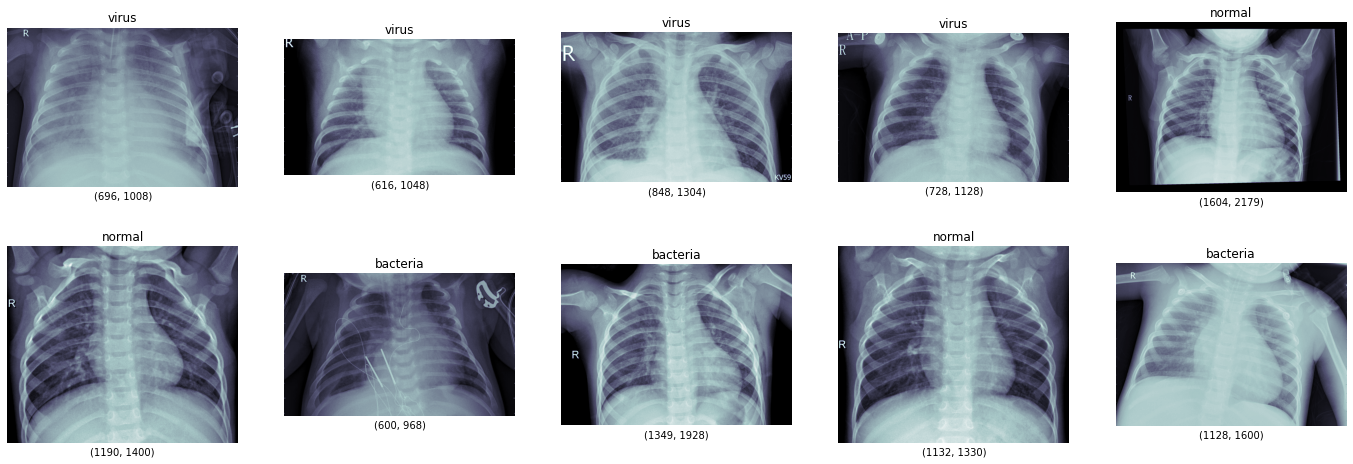

In [9]:
helpers.view_random_images(multi_train_dir, multi_class_names)

# Preprocessing

We'll start simple by normalizing our data

In [12]:
train_datagen = ImageDataGenerator(rescale=1 / 255., validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

In [13]:
binary_train_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

binary_val_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

binary_test_data = test_datagen.flow_from_directory(
    directory=binary_test_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
multi_train_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

multi_val_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

multi_test_data = test_datagen.flow_from_directory(
    directory=multi_test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 3 classes.
Found 1043 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


# Create models

## Fully connected dense models (baseline)

In [ ]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Flatten()(inputs)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)
x = layers.Dense(100, activation="relu")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_dense_model = Model(inputs=inputs,
                           outputs=outputs,
                           name="binary_dense_model")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_dense_model = Model(inputs=inputs,
                          outputs=outputs,
                          name="multi_dense_model")

Model: "binary_dense_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 100)               15052900  
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 output_layer (Dense)        (None, 1)                 101       
                                                                 
Total params: 15,073,201
Trainable params: 15,07

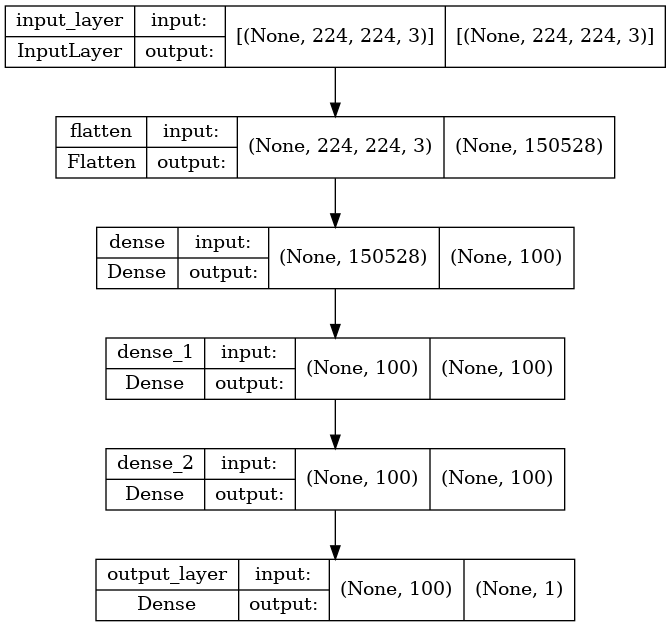

In [16]:
binary_dense_model.summary()
plot_model(binary_dense_model, show_shapes=True)

## Basic CNN: Tiny VGG

In [17]:
inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = layers.Conv2D(10, 3, activation='relu')(inputs)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.Conv2D(10, 3, activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="binary_tiny_vgg")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_tiny_vgg = Model(inputs=inputs, outputs=outputs, name="multi_tiny_vgg")

Model: "binary_tiny_vgg"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                   

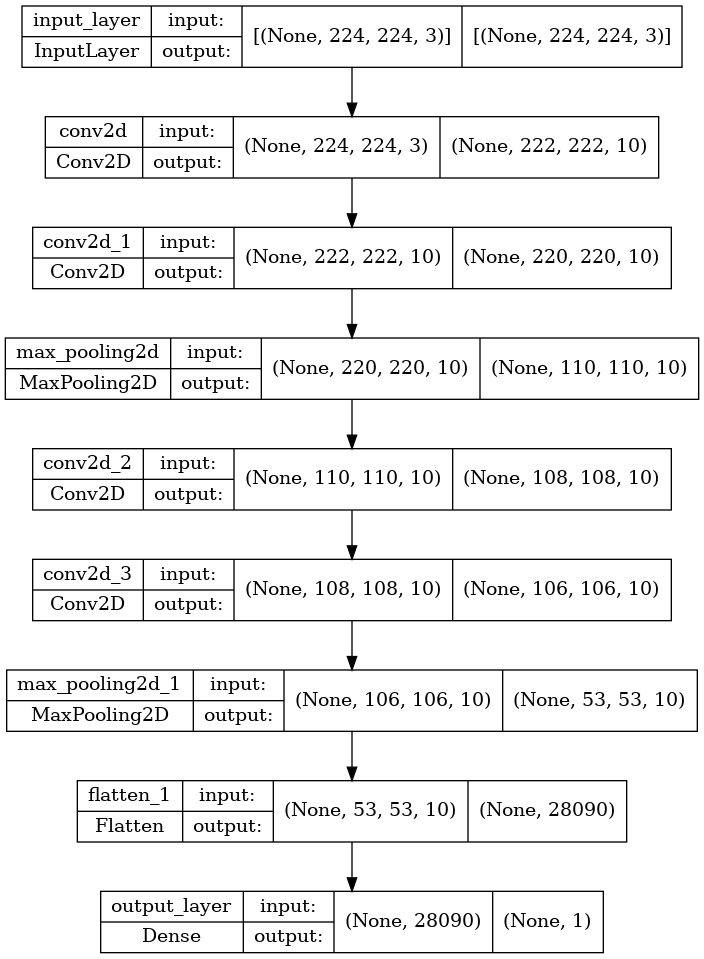

In [18]:
binary_tiny_vgg.summary()
plot_model(binary_tiny_vgg, show_shapes=True)

## Complex CNN: Densenet201

In [19]:
base_model = tf.keras.applications.DenseNet201(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(*IMG_SIZE, 3), name="input_layer")
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

outputs = layers.Dense(1, activation="sigmoid", name="output_layer")(x)
binary_densenet_201 = Model(inputs=inputs,
                            outputs=outputs,
                            name="binary_densenet_201")

outputs = layers.Dense(len(multi_class_names),
                       activation="softmax",
                       name="output_layer")(x)
multi_densenet_201 = Model(inputs=inputs,
                           outputs=outputs,
                           name="multi_densenet_201")

Model: "binary_densenet_201"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, None, None, 1920)  18321984  
                                                                 
 global_average_pooling_laye  (None, 1920)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 1)                 1921      
                                                                 
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


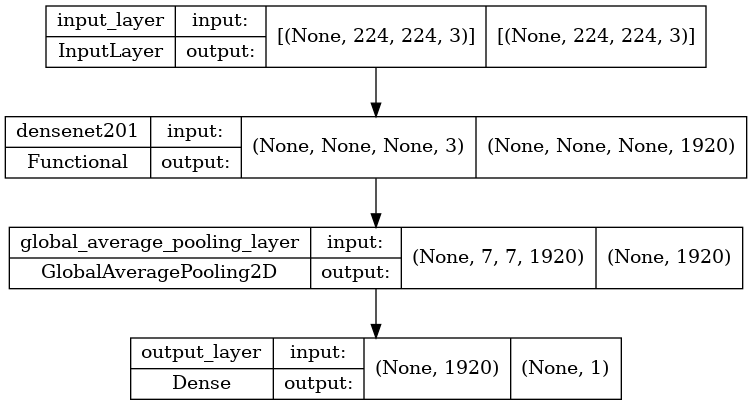

In [20]:
binary_densenet_201.summary()
plot_model(binary_densenet_201, show_shapes=True, )

In [28]:
# base_model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, None, None,   0          ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1/conv (Conv2D)            (None, None, None,   9408        ['zero_padding2d[0][0]']         
                                64)                                                     

# Train models

## Model compilations

In [21]:
binary_models = [binary_dense_model, binary_tiny_vgg, binary_densenet_201]
multi_models = [multi_dense_model, multi_tiny_vgg, multi_densenet_201]

for binary_model in binary_models:
    binary_model.compile(loss='binary_crossentropy',
                         optimizer=optimizers.Adam(),
                         metrics=['accuracy', 'Precision', 'Recall'])

for multi_model in multi_models:
    multi_model.compile(loss='categorical_crossentropy',
                        optimizer=optimizers.Adam(),
                        metrics=['accuracy', 'Precision', 'Recall'])

## Model trainings

In [22]:
tf.random.set_seed(SEED)

binary_histories = [
    binary_model.fit(binary_train_data,
                     epochs=EPOCHS,
                     validation_data=binary_val_data,
                     verbose=False) for binary_model in binary_models
]

multi_histories = [
    multi_model.fit(multi_train_data,
                    epochs=EPOCHS,
                    validation_data=multi_val_data,
                    verbose=False) for multi_model in multi_models
]

2022-05-11 10:14:52.230474: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-11 10:14:52.230537: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.59GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-11 10:14:58.094178: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.52GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-05-11 10:14:58.094243: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Alloc

## Model saving

In [23]:
for binary_model in binary_models:
    binary_model.save(f'binary_models/{binary_model._name}')
for multi_model in multi_models:
    multi_model.save(f'multi_models/{multi_model._name}')

2022-05-11 10:45:22.028650: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: binary_models/binary_dense_model/assets
INFO:tensorflow:Assets written to: binary_models/binary_tiny_vgg/assets
INFO:tensorflow:Assets written to: binary_models/binary_densenet_201/assets
INFO:tensorflow:Assets written to: multi_models/multi_dense_model/assets
INFO:tensorflow:Assets written to: multi_models/multi_tiny_vgg/assets
INFO:tensorflow:Assets written to: multi_models/multi_densenet_201/assets


In [ ]:
# !cp binary_models drive/MyDrive/tf_saved_models
# !cp multi_models drive/MyDrive/tf_saved_models

# Evaluate models

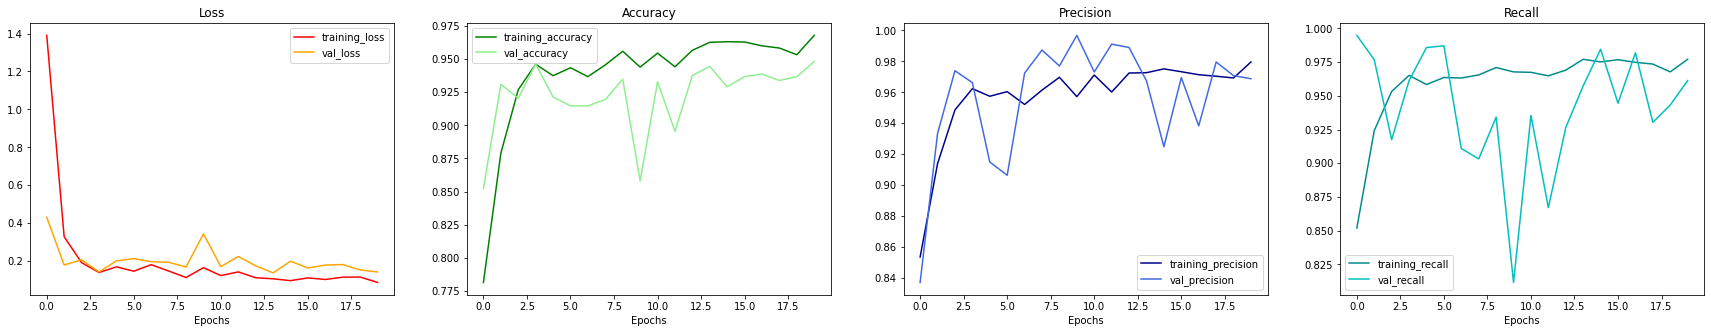

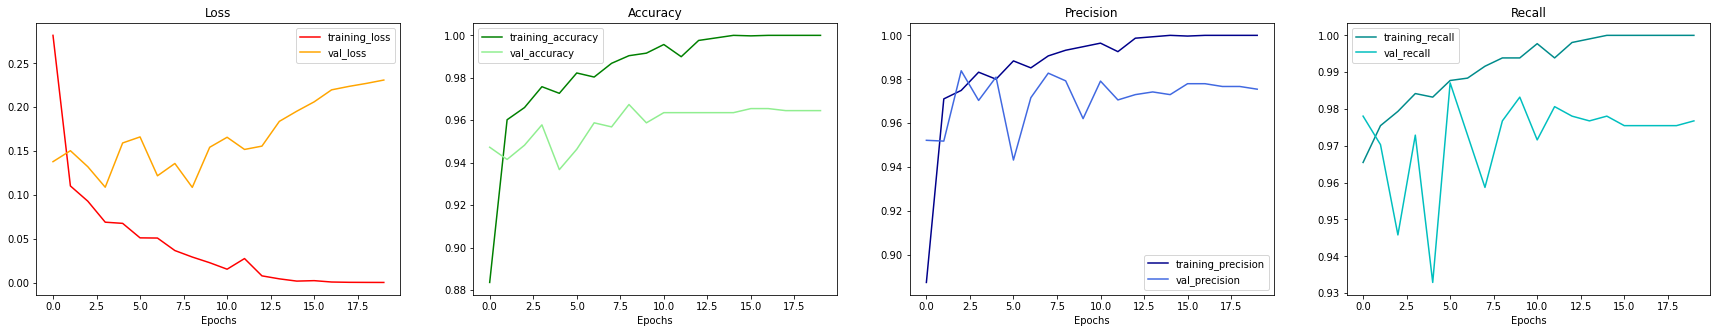

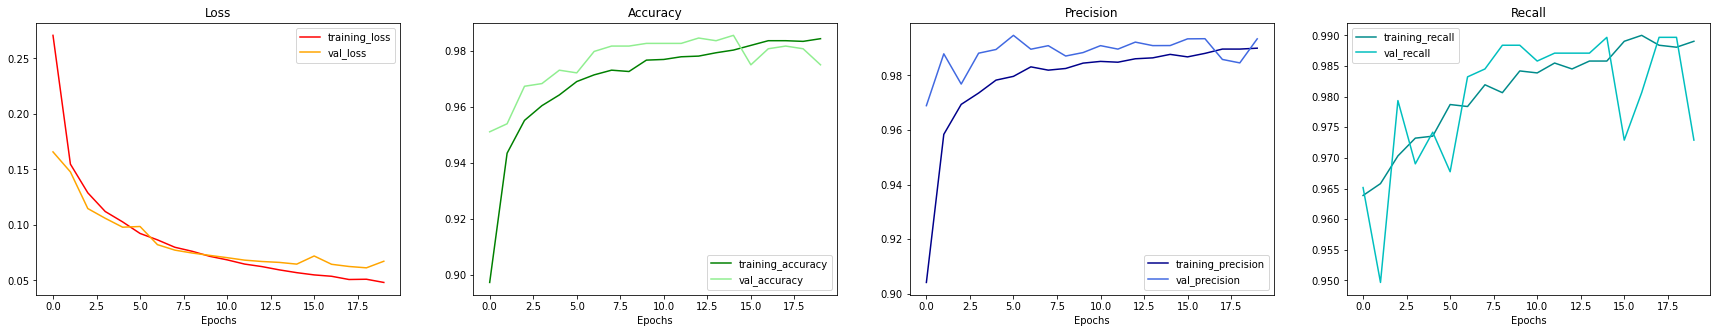

In [24]:
for binary_history in binary_histories:
  helpers.plot_loss_curves(binary_history)

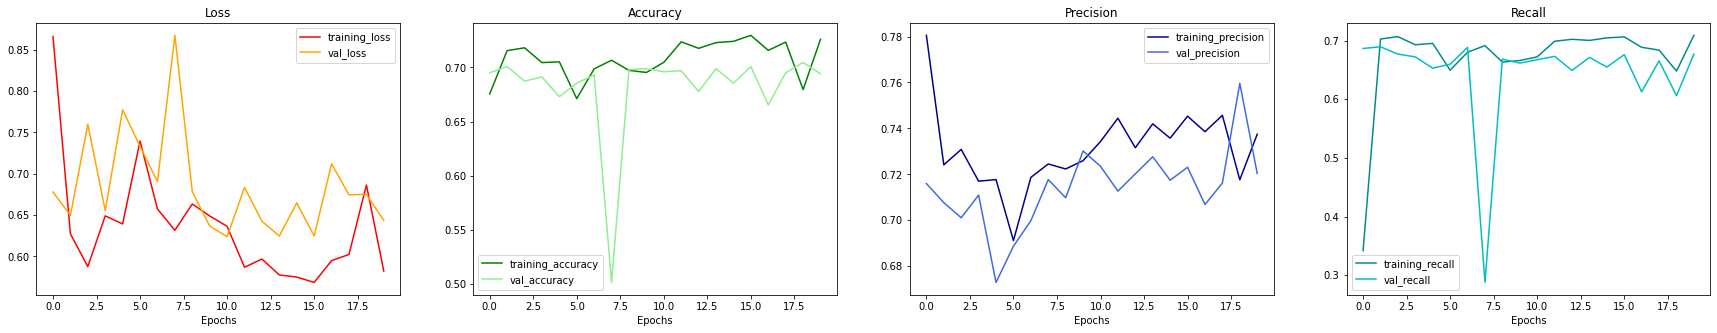

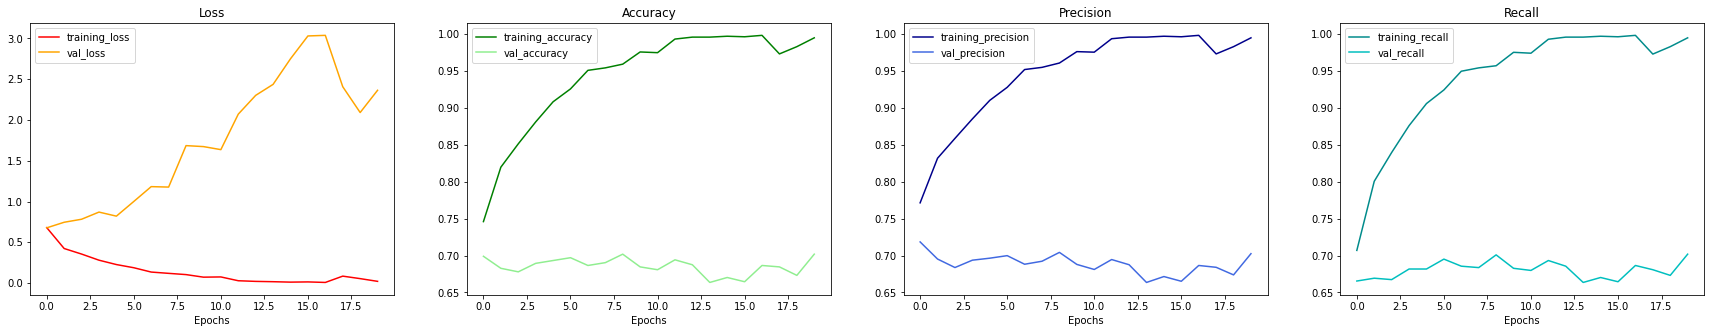

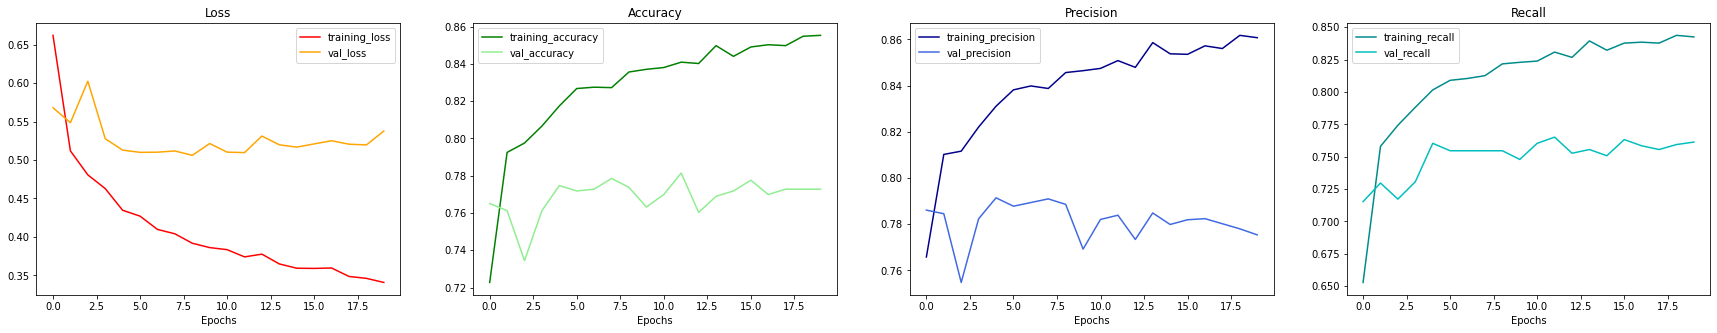

In [25]:
for multi_history in multi_histories:
  helpers.plot_loss_curves(multi_history)

As we can see, it seems that our convolutional models are slightly overfitting on the binary dataset but it is even more significant for the multi label dataset. Let's check their performance on the test sets.

## Metrics computation

In [29]:
binary_evaluation_scores, df = helpers.compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_dense_model,62.50%,62.50%,100.00%,76.92%
binary_tiny_vgg,80.61%,79.05%,93.85%,85.81%
binary_densenet_201,81.41%,77.62%,98.72%,86.91%


In [30]:
multi_evaluation_scores, df = helpers.compare_models(multi_models, multi_test_data, type='multi')
df

,accuracy,precision,recall,f1
model,,,,
multi_dense_model,53.04%,56.97%,53.04%,46.00%
multi_tiny_vgg,62.34%,71.22%,62.34%,60.48%
multi_densenet_201,69.71%,76.83%,69.71%,68.26%


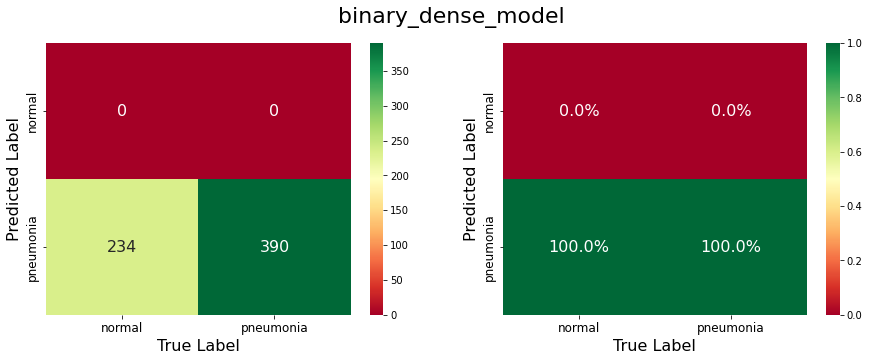

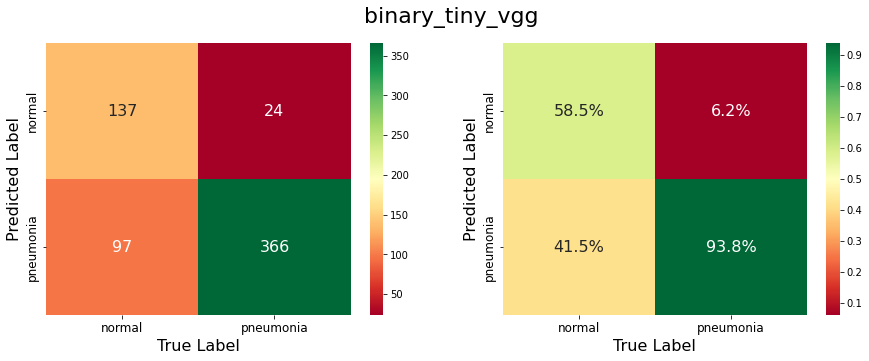

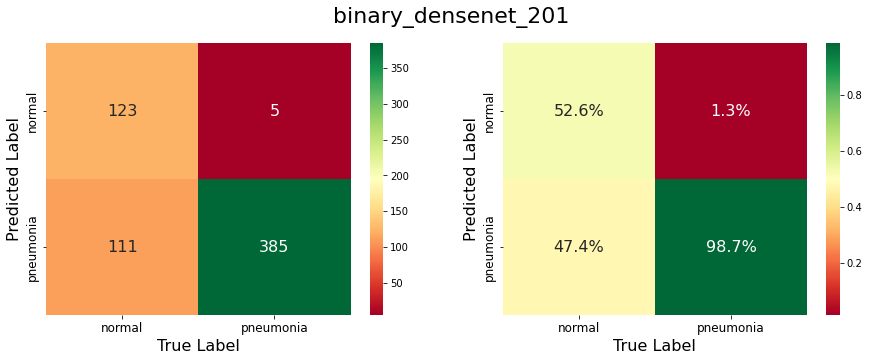

In [31]:
for i, (y_true, y_pred, _) in enumerate(binary_evaluation_scores):
  cm = confusion_matrix(y_true, y_pred)
  helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[i].name)

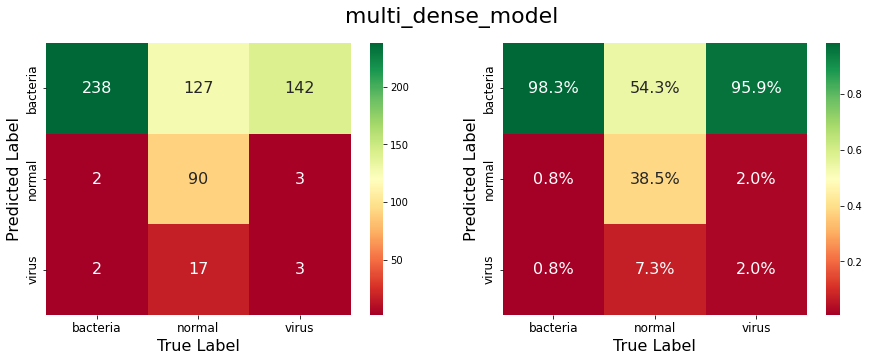

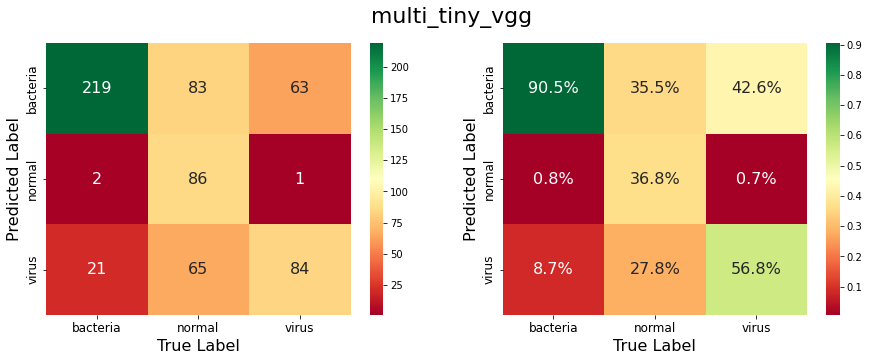

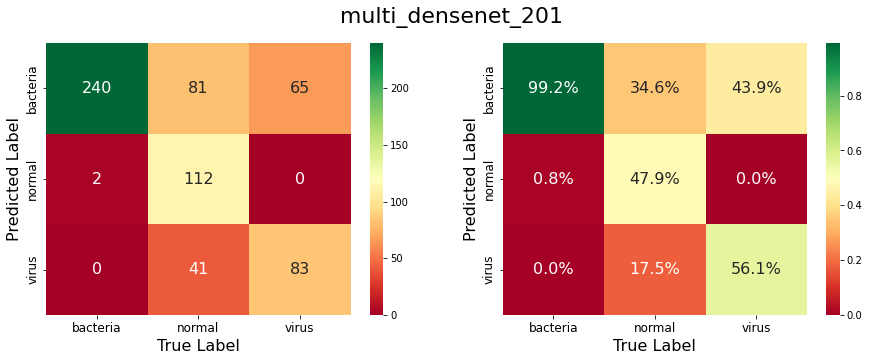

In [32]:
for i, (y_true, y_pred, _) in enumerate(multi_evaluation_scores):
  cm = confusion_matrix(y_true, y_pred)
  helpers.plot_confusion_matrixes(cm.T, multi_class_names, model_name=multi_models[i].name)

As we can see, the densenet model is the one with the most potential : without any optimization it outperforms both other model wether it is on the binary classification or the multi classification.

Since it has some overfitting problem, let's try out some different techniques to overcome this problem

# Optimize model

For now let's try to optimize our best model on binary classification

## Data augmentation

In [33]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=20,  # rotate the image slightly between 0 and 20 degrees
    shear_range=0.2,  # shear the image
    zoom_range=0.2,  # zoom into the image
    width_shift_range=0.2,  # shift the image width ways
    height_shift_range=0.2,  # shift the image height ways
    horizontal_flip=True,  # flip the image on the horizontal axis
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

In [34]:
binary_train_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

binary_val_data = train_datagen.flow_from_directory(
    directory=binary_train_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

binary_test_data = test_datagen.flow_from_directory(
    directory=binary_test_dir,
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model copy & training

Let's rebuild a clone of our best model so far
> 🔑 **Note**: We can't really use `tf.keras.models.clone_model` here because we need to copy the weights of the pre-**trained** densenet 201 model and not the one we just trained nor take random weights 

In [36]:
binary_densenet_201_v2, history = helpers.train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v2',
    img_size=IMG_SIZE,
    epochs=EPOCHS)


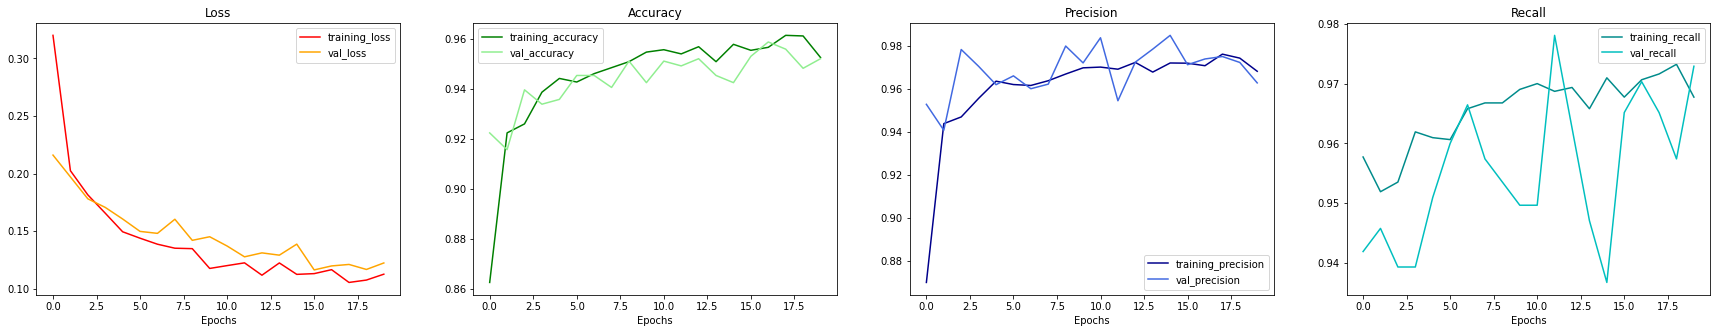

In [37]:
helpers.plot_loss_curves(history)

### Model saving

In [38]:
binary_densenet_201_v2.save(f'binary_models/{binary_densenet_201_v2.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v2/assets


In [21]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')

### Model evaluation

In [39]:
binary_models = [binary_densenet_201, binary_densenet_201_v2]
binary_evaluation_scores, df = helpers.compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,81.41%,77.62%,98.72%,86.91%
binary_densenet_201_v2,88.14%,85.91%,96.92%,91.08%


As we can see, data augmentation greatly helped reduce overfitting, thus improving our model's overall performance

Let's see how our confusion matrixes look like:

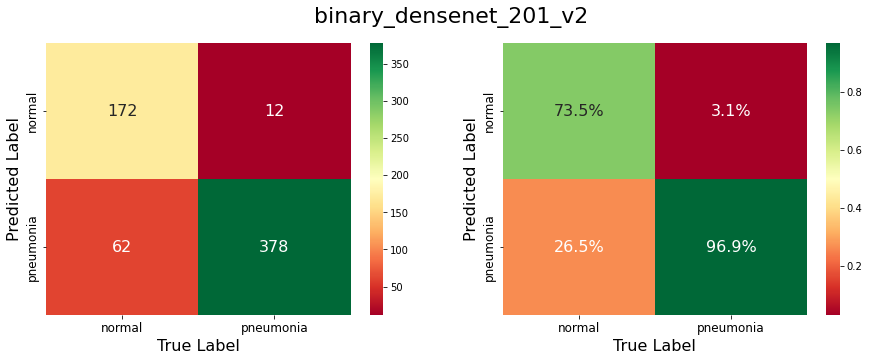

In [40]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Class balancing

It seems that our model still struggle to predict `normal` images
This could be explained by the fact that our training dataset in **unbalanced**:

In [41]:
print(
    f'In our training dataset, we have {normal_train_img_count} "normal" images and {pneumonia_train_img_count} "pneumonia" images for a total of {total_train_img_count} images'
)
print(
    f'This means that we have around {pneumonia_train_img_count/normal_train_img_count:.1f} times more "pneumonia" images'
)


In our training dataset, we have 1341 "normal" images and 3875 "pneumonia" images for a total of 5216 images
This means that we have around 2.9 times more "pneumonia" images


There are several different approaches to correct an unbalance dataset
- **Under-sampling**: balances the dataset by reducing the size of the abundant class
- **Over-sampling**: balance dataset by increasing the size of rare samples
- **Class weights calculation**: heavier weights are applied to the minority classes, indicating the model must give more importance to these classes

In [42]:
normal_ratio = normal_train_img_count / total_train_img_count
normal_weight = 1 / (len(binary_class_names) * normal_ratio)
pneumonia_ratio = pneumonia_train_img_count / total_train_img_count
pneumonia_weight = 1 / (len(binary_class_names) * pneumonia_ratio)

binary_class_weight = {0: normal_weight, 1: pneumonia_weight}

print(f'Weight for class {binary_class_names[0]}: {normal_weight:.2f}')
print(f'Weight for class {binary_class_names[1]}: {pneumonia_weight:.2f}')

Weight for class normal: 1.94
Weight for class pneumonia: 0.67


### Model copy & training

In [43]:
binary_densenet_201_v3, history = helpers.train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v3',
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    class_weight=binary_class_weight)

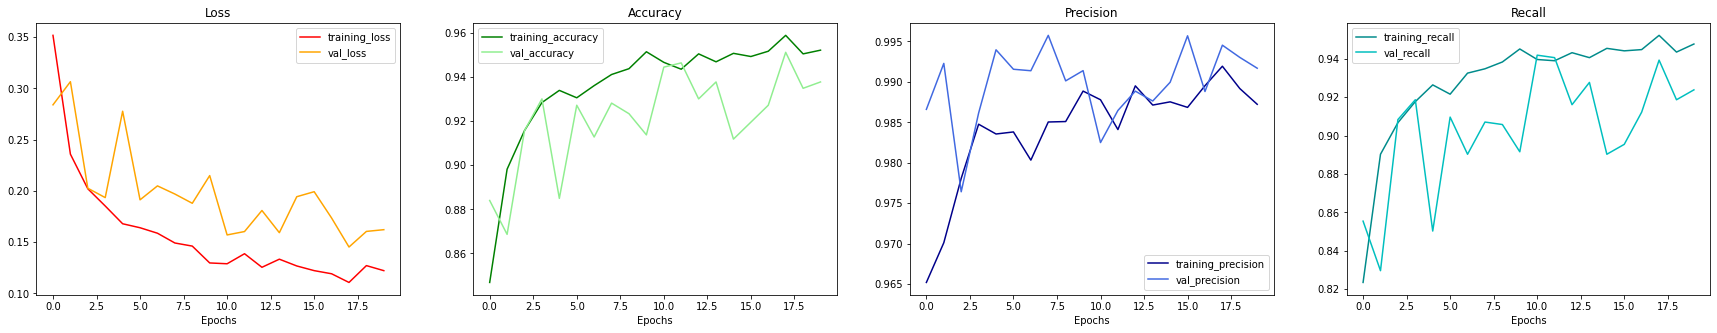

In [44]:
helpers.plot_loss_curves(history)

### Model saving

In [45]:
binary_densenet_201_v3.save(f'binary_models/{binary_densenet_201_v3.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v3/assets


In [19]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')
binary_densenet_201_v3 = models.load_model('binary_models/binary_densenet_201_v3')

### Model evaluation

In [46]:
binary_models = [binary_densenet_201, binary_densenet_201_v2, binary_densenet_201_v3]
binary_evaluation_scores, df = helpers.compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,81.41%,77.62%,98.72%,86.91%
binary_densenet_201_v2,88.14%,85.91%,96.92%,91.08%
binary_densenet_201_v3,89.10%,91.49%,91.03%,91.26%


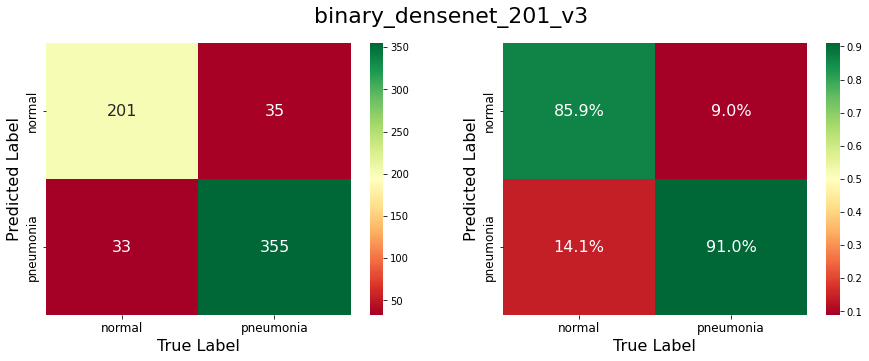

In [47]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Fine tuning

With the combination of data augmentation and class balancing, we were able to reach (almost) 90% on every metrics!

Let's try to optimize our model's performance with one last method: unfreeze its weights (which is also called fine tuning)

### Model copy & training

In [48]:
binary_densenet_201_v4, history = helpers.train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v4',
    fine_tune_model=True,
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    class_weight=binary_class_weight)

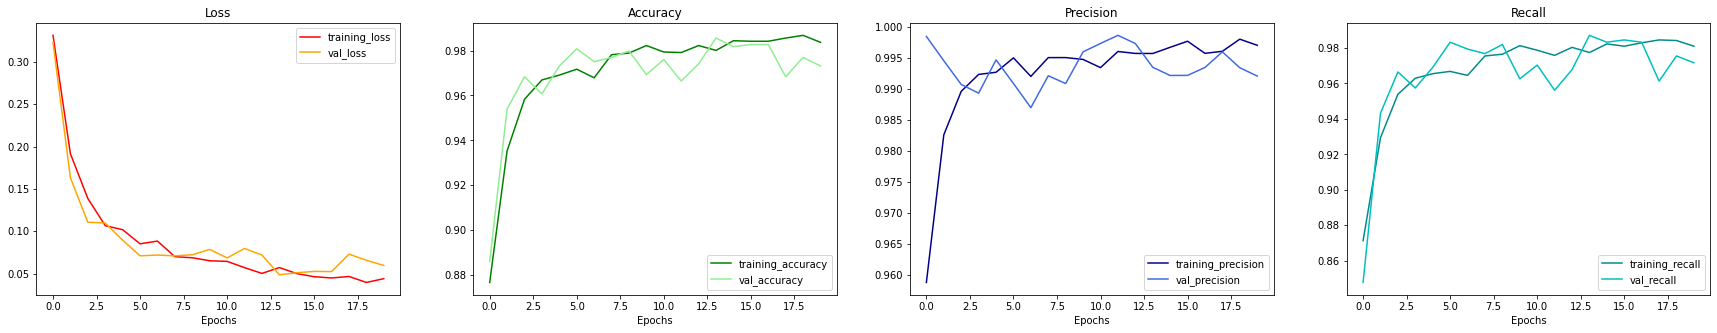

In [49]:
helpers.plot_loss_curves(history)

### Model saving

In [50]:
binary_densenet_201_v4.save(f'binary_models/{binary_densenet_201_v4.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v4/assets


In [34]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')
binary_densenet_201_v3 = models.load_model('binary_models/binary_densenet_201_v3')
binary_densenet_201_v4 = models.load_model('binary_models/binary_densenet_201_v4')

### Model evaluation

In [51]:
binary_models = [binary_densenet_201, binary_densenet_201_v2, binary_densenet_201_v3, binary_densenet_201_v4]
binary_evaluation_scores, df = helpers.compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,81.41%,77.62%,98.72%,86.91%
binary_densenet_201_v2,88.14%,85.91%,96.92%,91.08%
binary_densenet_201_v3,89.10%,91.49%,91.03%,91.26%
binary_densenet_201_v4,93.11%,91.81%,97.69%,94.66%


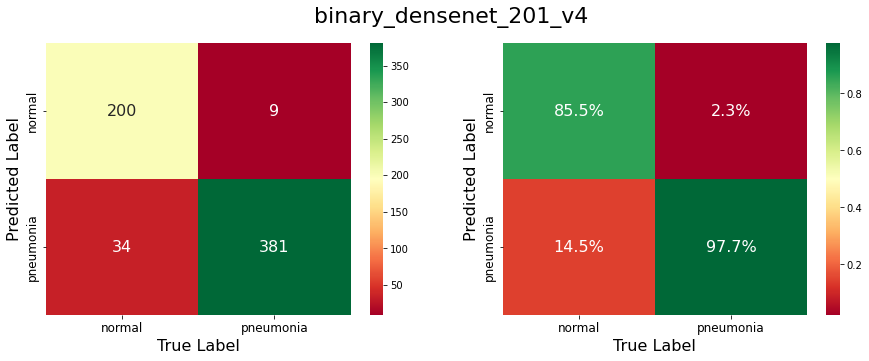

In [52]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

## Push to limit

It seems that our last models still slightly improving after 20 epochs: let's try to push its training to the limit!

In [53]:
binary_densenet_201_v5, history = helpers.train_new_densenet201_model(
    binary_train_data,
    binary_val_data,
    seed=SEED,
    name='binary_densenet_201_v5',
    fine_tune_model=True,
    img_size=IMG_SIZE,
    epochs=5*EPOCHS,
    class_weight=binary_class_weight)

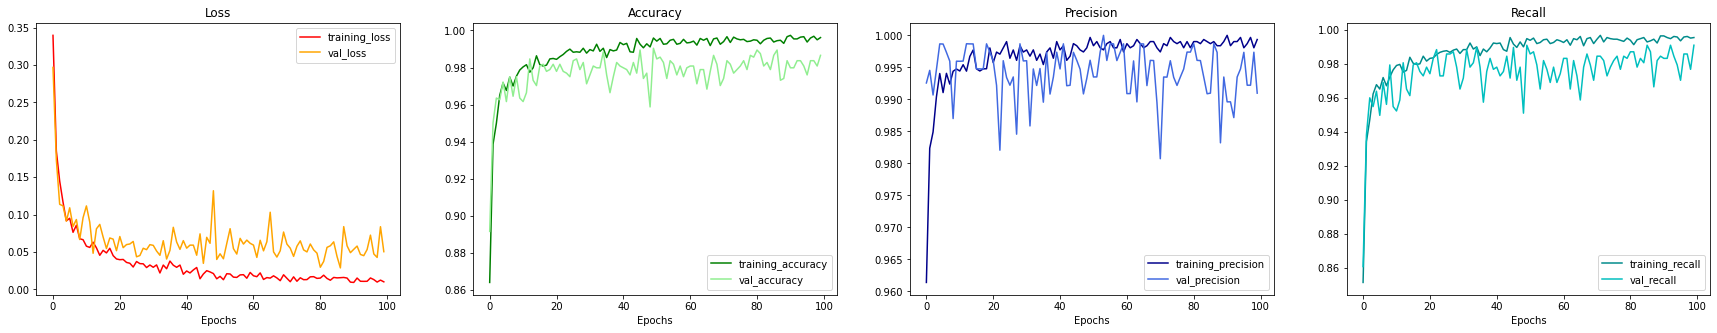

In [54]:
helpers.plot_loss_curves(history)

In [55]:
binary_densenet_201_v5.save(f'binary_models/{binary_densenet_201_v5.name}')

INFO:tensorflow:Assets written to: binary_models/binary_densenet_201_v5/assets


In [ ]:
binary_densenet_201 = models.load_model('binary_models/binary_densenet_201')
binary_densenet_201_v2 = models.load_model('binary_models/binary_densenet_201_v2')
binary_densenet_201_v3 = models.load_model('binary_models/binary_densenet_201_v3')
binary_densenet_201_v4 = models.load_model('binary_models/binary_densenet_201_v4')
binary_densenet_201_v5 = models.load_model('binary_models/binary_densenet_201_v5')

In [56]:
binary_models = [binary_densenet_201, binary_densenet_201_v2, binary_densenet_201_v3, binary_densenet_201_v4, binary_densenet_201_v5]
binary_evaluation_scores, df = helpers.compare_models(binary_models, binary_test_data)
df

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201,81.41%,77.62%,98.72%,86.91%
binary_densenet_201_v2,88.14%,85.91%,96.92%,91.08%
binary_densenet_201_v3,89.10%,91.49%,91.03%,91.26%
binary_densenet_201_v4,93.11%,91.81%,97.69%,94.66%
binary_densenet_201_v5,92.15%,90.31%,97.95%,93.97%


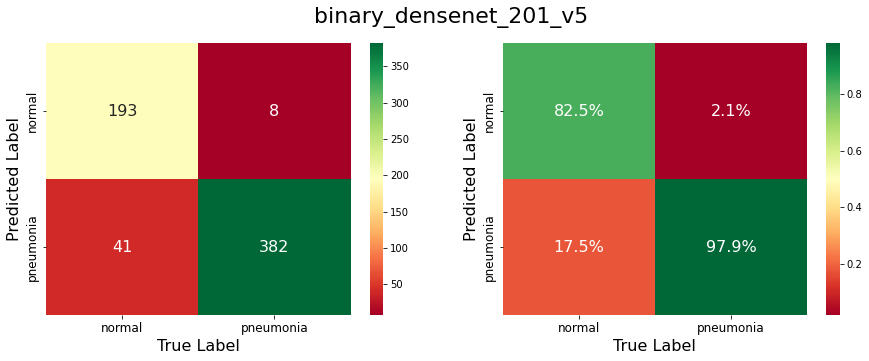

In [57]:
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_models[-1].name)

As we can see the problem with training too long is that our model is inavitably going to overfit.

# Multi label classification

Now that we've optimized as best as we could the densenet_201 model, let's try it on the multi label dataset and see how it performs. We'll be using our best configuration so far, the v4.

## Preprocessing

In [77]:
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=20,  # rotate the image slightly between 0 and 20 degrees
    shear_range=0.2,  # shear the image
    zoom_range=0.2,  # zoom into the image
    width_shift_range=0.2,  # shift the image width ways
    height_shift_range=0.2,  # shift the image height ways
    horizontal_flip=True,  # flip the image on the horizontal axis
    validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1 / 255.)

In [85]:
multi_train_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='training')

multi_val_data = train_datagen.flow_from_directory(
    directory=multi_train_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED,
    subset='validation')

multi_test_data = test_datagen.flow_from_directory(
    directory=multi_test_dir,
    target_size=IMG_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=SEED)

Found 4173 images belonging to 3 classes.
Found 1043 images belonging to 3 classes.
Found 624 images belonging to 3 classes.


In [86]:
bacteria_ratio = bacteria_train_img_count / total_train_img_count
bacteria_weight = 1 / (len(multi_class_names) * bacteria_ratio)

normal_ratio = normal_train_img_count / total_train_img_count
normal_weight = 1 / (len(multi_class_names) * normal_ratio)

virus_ratio = virus_train_img_count / total_train_img_count
virus_weight = 1 / (len(multi_class_names) * virus_ratio)

multi_class_weight = {0: bacteria_weight, 1: normal_weight, 2: virus_weight}

print(f'Weight for class {multi_class_names[0]}: {bacteria_weight:.2f}')
print(f'Weight for class {multi_class_names[1]}: {normal_weight:.2f}')
print(f'Weight for class {multi_class_names[2]}: {virus_weight:.2f}')

Weight for class bacteria: 0.69
Weight for class normal: 1.30
Weight for class virus: 1.29


## Training

In [88]:
multi_densenet_201_v2, history = helpers.train_new_densenet201_model(
    multi_train_data,
    multi_val_data,
    type='categorical',
    seed=SEED,
    name='multi_densenet_201_v2',
    fine_tune_model=True,
    img_size=IMG_SIZE,
    epochs=EPOCHS,
    class_weight=multi_class_weight)

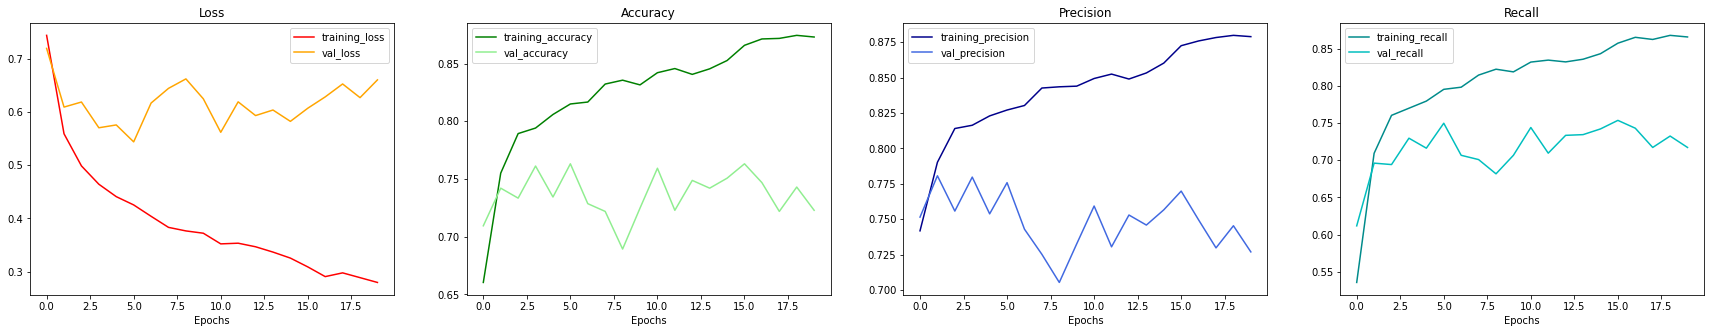

In [89]:
helpers.plot_loss_curves(history)

In [90]:
multi_densenet_201_v2.save(f'multi_models/{multi_densenet_201_v2.name}')

In [95]:
multi_densenet_201 = models.load_model('multi_models/multi_densenet_201')
multi_densenet_201_v2 = models.load_model('multi_models/multi_densenet_201_v2')

In [96]:
multi_models = [multi_densenet_201, multi_densenet_201_v2]
multi_evaluation_scores, df = helpers.compare_models(multi_models, multi_test_data, type='multi')
df

,accuracy,precision,recall,f1
model,,,,
multi_densenet_201,69.71%,76.83%,69.71%,68.26%
multi_densenet_201_v2,87.02%,87.92%,87.02%,87.25%


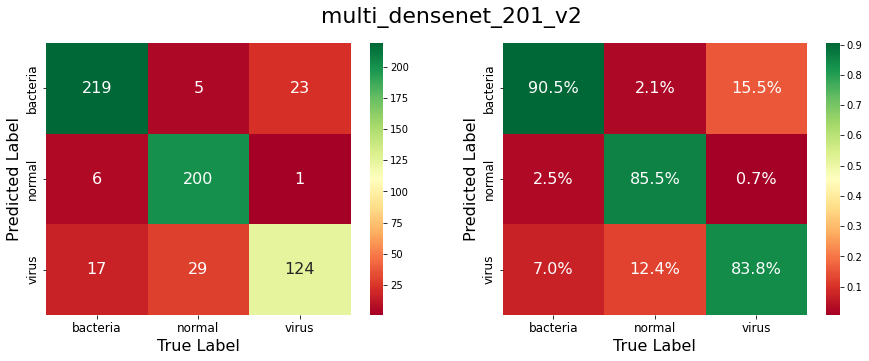

In [97]:
y_true, y_pred, _ = multi_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, multi_class_names, model_name=multi_models[-1].name)

# Final scores

## Binary classification

,accuracy,precision,recall,f1
model,,,,
binary_densenet_201_v4,93.11%,91.81%,97.69%,94.66%


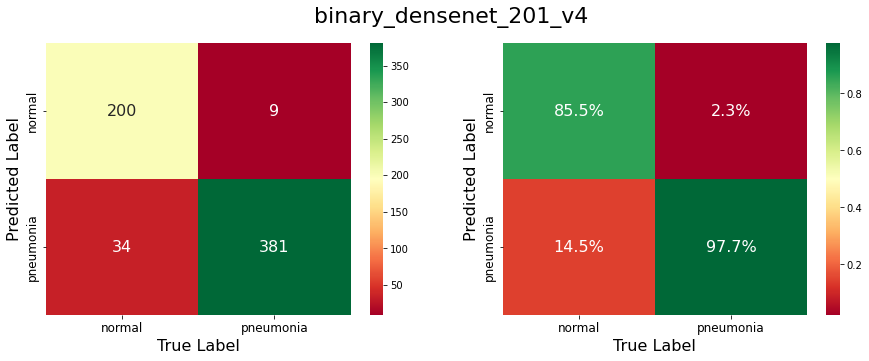

In [98]:
binary_evaluation_scores, df = helpers.compare_models([binary_densenet_201_v4], binary_test_data)
y_true, y_pred, _ = binary_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, binary_class_names, model_name=binary_densenet_201_v4.name)
df

## Multi classification

,accuracy,precision,recall,f1
model,,,,
multi_densenet_201_v2,87.02%,87.92%,87.02%,87.25%


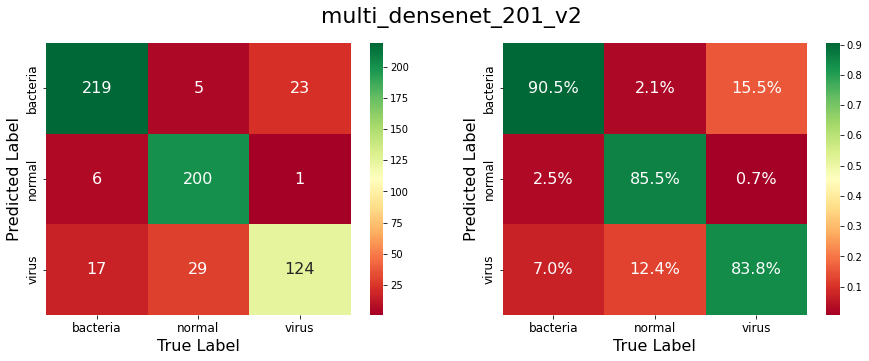

In [100]:
multi_evaluation_scores, df = helpers.compare_models([multi_densenet_201_v2], multi_test_data, type='multi')
y_true, y_pred, _ = multi_evaluation_scores[-1]
cm = confusion_matrix(y_true, y_pred)
helpers.plot_confusion_matrixes(cm.T, multi_class_names, model_name=multi_densenet_201_v2.name)
df